# Discriminative Score Validation - KSS Method

This notebook validates the KSS discriminative scoring method against standard feature selection metrics for genomic position classification. Evaluation is performed using 100-fold stratified cross-validation across viral datasets.

**Author:** KSS Project  
**Date:** 2025-01-19

## 1. Imports and Configuration

In [1]:
import sys
import json
import warnings
from pathlib import Path
from collections import Counter
from typing import Dict, Tuple, Any

import numpy as np
import pandas as pd

from sklearn.feature_selection import mutual_info_classif, chi2
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, normalized_mutual_info_score
from scipy.stats import f_oneway, chi2_contingency

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib as mpl
from matplotlib.patches import Patch

from joblib import Parallel, delayed

warnings.filterwarnings('ignore')

project_root = Path.cwd().parent
sys.path.insert(0, str(project_root / 'src'))

import kss
from discriminative_score import get_discriminative_score

## 2. Dataset and Validation Configuration

In [2]:
DATASETS = {
    "HCMV": {
        "name": "Human_betaherpesvirus_5",
        "genes": ["UL55", "UL73", "US28"],
        "description": "Human Cytomegalovirus",
        "pool_genes": False
    },
    "HIV-1": {
        "name": "Human_immunodeficiency_virus_1",
        "genes": ["gag", "pol", "env"],
        "description": "Human Immunodeficiency Virus 1",
        "pool_genes": True
    },
    "SARS-CoV-2": {
        "name": "Severe_acute_respiratory_syndrome_coronavirus_2",
        "genes": ["ORF1ab", "S", "N", "M", "E"],
        "description": "SARS Coronavirus 2",
        "pool_genes": True
    }
}

N_ITERATIONS = 100
RANDOM_STATE_BASE = 42
TOP_K_VALUES = [1, 2, 3, 5, 7, 10, 15, 20, 25]
MIN_TRAIN_PER_CLASS = 20
MAX_TRAIN_PER_CLASS = 500
TRAIN_RATIO = 0.70
SVM_C = 1.0
SVM_MAX_ITER = 10000
N_JOBS = 10
BASE_PATH = project_root / "data"
OUTPUT_PATH = Path.cwd() / "discriminative_score_validation_results"
OUTPUT_PATH.mkdir(parents=True, exist_ok=True)

print(f"Configuration: {len(DATASETS)} datasets, {N_ITERATIONS} iterations, {N_JOBS} workers")
print(f"Output: {OUTPUT_PATH}")

Configuration: 3 datasets, 100 iterations, 10 workers
Output: c:\Users\lebat\Documents\Projects\KSS\notebooks\discriminative_score_validation_results


## 3. Data Loading

In [41]:
def load_gene_data(dataset_name: str, gene: str) -> Dict[str, Any]:
    gene_path = BASE_PATH / dataset_name / gene / "results"

    compiled_file = gene_path / f"{gene}_compiled_results.json"
    with open(compiled_file, 'r') as f:
        compiled_data = json.load(f)[gene]

    results_file = gene_path / f"{gene}_results.json"
    with open(results_file, 'r') as f:
        results_data = json.load(f)

    gene_data_raw = results_data['genes'][gene]
    gene_sequences = gene_data_raw['sequences']
    gene_metadata = gene_data_raw['metadata']

    X, kmers_variants, labels, seq_ids = kss.build_feature_matrix(gene_sequences, compiled_data)

    k = 9
    all_positions_grid = kss._get_all_positions(gene_metadata, k)
    positions_in_compiled = [int(p) for p in compiled_data.keys()]
    all_positions = sorted(set(all_positions_grid) | set(positions_in_compiled))

    return {
        'compiled_data': compiled_data,
        'gene_sequences': gene_sequences,
        'feature_matrix': X,
        'labels': np.array(labels),
        'seq_ids': seq_ids,
        'kmers_variants': kmers_variants,
        'all_positions': all_positions,
        'reference_length': gene_metadata.get('reference_length', 0)
    }


def load_all_datasets() -> Tuple[Dict[str, Dict[str, Dict[str, Any]]], Dict[str, Dict[str, Dict[str, Any]]]]:
    all_data = {}
    gene_cache = {}

    for dataset_key, dataset_info in DATASETS.items():
        dataset_name = dataset_info['name']
        pool_genes = dataset_info.get('pool_genes', False)

        if pool_genes:
            all_data[dataset_key] = {}
            gene_cache[dataset_key] = {}

            pooled_compiled_data = {}
            pooled_gene_sequences = {}
            pooled_all_positions = []
            pooled_kmers_variants = {}
            pooled_labels = None
            pooled_seq_ids = None
            pooled_reference_length = 0

            for gene in dataset_info['genes']:
                try:
                    gene_data = load_gene_data(dataset_name, gene)
                    gene_cache[dataset_key][gene] = gene_data

                    # Merge with gene prefix
                    for pos_str, pos_data in gene_data['compiled_data'].items():
                        pooled_compiled_data[f"{gene}:{pos_str}"] = pos_data

                    if not pooled_gene_sequences:
                        pooled_gene_sequences = gene_data['gene_sequences']

                    for pos in gene_data['all_positions']:
                        pooled_all_positions.append(f"{gene}:{pos}")

                    for pos_str, kmer_data in gene_data['kmers_variants'].items():
                        pooled_kmers_variants[f"{gene}:{pos_str}"] = kmer_data

                    if pooled_labels is None:
                        pooled_labels = gene_data['labels']
                        pooled_seq_ids = gene_data['seq_ids']

                    pooled_reference_length += gene_data['reference_length']

                except Exception as e:
                    print(f"   {dataset_key:12s} / {gene:8s} - ERROR: {e}")
            all_data[dataset_key]['pooled'] = {
                'compiled_data': pooled_compiled_data,
                'gene_sequences': pooled_gene_sequences,
                'feature_matrix': np.array([]),
                'labels': pooled_labels,
                'seq_ids': pooled_seq_ids,
                'kmers_variants': pooled_kmers_variants,
                'all_positions': pooled_all_positions,
                'reference_length': pooled_reference_length,
                'genes_included': dataset_info['genes']
            }

        else:
            all_data[dataset_key] = {}

            for gene in dataset_info['genes']:
                try:
                    gene_data = load_gene_data(dataset_name, gene)
                    all_data[dataset_key][gene] = gene_data

                except Exception as e:
                    print(f"   {dataset_key:12s} / {gene:8s} - ERROR: {e}")

    total_datasets = len(all_data)
    total_entries = sum(len(genes) for genes in all_data.values())
    print(f"Loaded: {total_datasets} datasets, {total_entries} entries")

    return all_data, gene_cache

## 4. Discriminative Scoring Functions

In [42]:
def calculate_discriminative_score(X: np.ndarray, y: np.ndarray) -> float:
    """Calculate KSS discriminative score."""
    try:
        result = get_discriminative_score(X, y)
        return result['normalized_score']
    except Exception:
        return 0.0


def calculate_nmi(X: np.ndarray, y: np.ndarray) -> float:
    """Calculate normalized mutual information."""
    try:
        X_categorical = np.apply_along_axis(
            lambda row: ''.join(map(str, row.astype(int))),
            axis=1,
            arr=X
        )
        nmi_score = normalized_mutual_info_score(y, X_categorical, average_method='arithmetic')
        return float(nmi_score)
    except Exception:
        return 0.0


def calculate_mi_score(X: np.ndarray, y: np.ndarray) -> float:
    """Calculate mutual information score (sum across features)."""
    try:
        mi_scores = mutual_info_classif(X, y, discrete_features=True)
        return float(np.sum(mi_scores))
    except Exception:
        return 0.0


def calculate_chi2_score(X: np.ndarray, y: np.ndarray) -> float:
    """Calculate chi-squared score (sum across features)."""
    try:
        chi2_scores, _ = chi2(X, y)
        return float(np.sum(chi2_scores))
    except Exception:
        return 0.0


def calculate_anova_score(X: np.ndarray, y: np.ndarray) -> float:
    """Calculate ANOVA F-statistic (sum across features)."""
    try:
        unique_classes = np.unique(y)
        f_stats = []

        for j in range(X.shape[1]):
            groups = [X[y == cls, j] for cls in unique_classes]

            with warnings.catch_warnings():
                warnings.filterwarnings('ignore', category=RuntimeWarning)
                try:
                    f_stat, _ = f_oneway(*groups)
                    if np.isnan(f_stat):
                        f_stat = 0.0
                    elif np.isinf(f_stat):
                        f_stat = 1e10
                except Exception:
                    f_stat = 0.0

            f_stats.append(f_stat)

        return float(np.sum(f_stats))
    except Exception:
        return 0.0


def calculate_odds_ratio_score(X: np.ndarray, y: np.ndarray) -> float:
    """Calculate odds ratio score (sum of absolute log odds ratios)."""
    try:
        class_counts = Counter(y)
        most_common_class = class_counts.most_common(1)[0][0]
        y_bin = (y == most_common_class).astype(int)

        log_ors = []
        for j in range(X.shape[1]):
            present = X[:, j] == 1
            absent = ~present

            a = np.sum(present & (y_bin == 1))
            b = np.sum(present & (y_bin == 0))
            c = np.sum(absent & (y_bin == 1))
            d = np.sum(absent & (y_bin == 0))

            # Laplace smoothing
            a, b, c, d = a + 0.5, b + 0.5, c + 0.5, d + 0.5

            odds_ratio = (a * d) / (b * c)
            log_ors.append(np.log(odds_ratio))

        return float(np.sum(np.abs(log_ors)))
    except Exception:
        return 0.0


def calculate_cramer_v_score(X: np.ndarray, y: np.ndarray) -> float:
    """Calculate Cramér's V statistic."""
    try:
        n_samples = X.shape[0]
        n_classes = len(np.unique(y))

        if n_classes < 2:
            return 0.0

        unique_configs, config_ids = np.unique(X, axis=0, return_inverse=True)
        n_configs = len(unique_configs)

        unique_classes = np.unique(y)
        contingency = np.zeros((n_configs, len(unique_classes)))

        for i in range(n_configs):
            mask = (config_ids == i)
            for k, c_val in enumerate(unique_classes):
                contingency[i, k] = np.sum(y[mask] == c_val)

        chi2_stat, _, _, _ = chi2_contingency(contingency)
        r, k = contingency.shape
        v = np.sqrt(chi2_stat / (n_samples * min(k - 1, r - 1)))

        return float(v)

    except Exception:
        return 0.0


def calculate_all_metrics(X: np.ndarray, y: np.ndarray) -> Dict[str, float]:
    """Calculate all discriminative metrics for a genomic position."""
    return {
        'KSS_discriminative': calculate_discriminative_score(X, y),
        'Chi2': calculate_chi2_score(X, y),
        'MI': calculate_mi_score(X, y),
        'OddsRatio': calculate_odds_ratio_score(X, y),
        'CramerV': calculate_cramer_v_score(X, y),
        'ANOVA': calculate_anova_score(X, y),
        'NMI': calculate_nmi(X, y),
    }

## 5. Position Feature Matrices

In [43]:
def build_position_feature_matrix(gene_data: Dict[str, Any], position: str) -> Tuple[np.ndarray, np.ndarray]:
    """Build feature matrix for a single genomic position."""
    pos_str = str(position)
    compiled_data = gene_data['compiled_data']
    labels = gene_data['labels']

    if pos_str in compiled_data:
        # Position with mutations
        kmers_variants = gene_data['kmers_variants']

        if pos_str not in kmers_variants:
            return None, None

        col_indices = kmers_variants[pos_str]['col_indices']
        X_position = gene_data['feature_matrix'][:, col_indices]
        y = labels

        if X_position.shape[1] == 0:
            return None, None

    else:
        # Invariant position (all REF)
        n_sequences = len(labels)
        X_position = np.ones((n_sequences, 1), dtype=int)
        y = labels

    return X_position, y


def build_all_position_matrices(all_data: Dict, gene_cache: Dict) -> Dict[str, Dict[str, Dict[str, Tuple[np.ndarray, np.ndarray]]]]:
    """Build position-specific feature matrices for all genomic positions."""
    print("Building position feature matrices...")

    position_matrices = {}
    total_positions = 0
    total_invariant = 0
    total_failed = 0

    for dataset_key, genes_data in all_data.items():
        position_matrices[dataset_key] = {}
        dataset_info = DATASETS[dataset_key]
        pool_genes = dataset_info.get('pool_genes', False)

        if pool_genes:
            gene_feature_data = gene_cache.get(dataset_key, {})

            if not gene_feature_data:
                continue

            pooled_data = genes_data['pooled']
            position_matrices[dataset_key]['pooled'] = {}

            n_pos = 0
            n_inv = 0
            n_fail = 0

            for position in pooled_data['all_positions']:
                position_str = str(position)

                if ':' in position_str:
                    gene_name, pos_str = position_str.split(':', 1)

                    try:
                        pos_int = int(pos_str)
                    except ValueError:
                        n_fail += 1
                        continue

                    if gene_name in gene_feature_data:
                        gene_data = gene_feature_data[gene_name]
                        X_pos, y = build_position_feature_matrix(gene_data, pos_int)

                        if X_pos is not None:
                            position_matrices[dataset_key]['pooled'][position] = (X_pos, y)
                            n_pos += 1

                            if X_pos.shape[1] == 1 and np.all(X_pos == 1):
                                n_inv += 1
                        else:
                            n_fail += 1
                    else:
                        n_fail += 1
                else:
                    n_fail += 1

            total_positions += n_pos
            total_invariant += n_inv
            total_failed += n_fail

            print(f"  {dataset_key} / POOLED: {n_pos} positions ({n_inv} invariant)")

        else:
            for gene, gene_data in genes_data.items():
                position_matrices[dataset_key][gene] = {}

                n_pos = 0
                n_inv = 0
                n_fail = 0

                for position in gene_data['all_positions']:
                    X_pos, y = build_position_feature_matrix(gene_data, position)

                    if X_pos is not None:
                        position_matrices[dataset_key][gene][position] = (X_pos, y)
                        n_pos += 1

                        if X_pos.shape[1] == 1 and np.all(X_pos == 1):
                            n_inv += 1
                    else:
                        n_fail += 1

                total_positions += n_pos
                total_invariant += n_inv
                total_failed += n_fail

                print(f"  {dataset_key} / {gene}: {n_pos} positions ({n_inv} invariant)")

    print(f"\nTotal: {total_positions:,} positions ({total_positions - total_invariant:,} variants, {total_invariant:,} invariant)")

    return position_matrices

## 6. Score Calculation (Train-Only)

In [44]:
def calculate_scores_train_only(position_matrices: Dict, train_idx: np.ndarray, dataset_key: str, gene: str) -> pd.DataFrame:
    """
    Calculate discriminative scores for all positions using training data.

    Parameters
    ----------
    position_matrices : Dict
        Dictionary containing position feature matrices
    train_idx : np.ndarray
        Indices of training samples
    dataset_key : str
        Dataset key (e.g., 'HCMV', 'HIV-1', 'SARS-CoV-2')
    gene : str
        Gene name or 'pooled'

    Returns
    -------
    pd.DataFrame
        DataFrame with scores for all positions
    """
    if dataset_key not in position_matrices:
        raise ValueError(f"Dataset '{dataset_key}' not found")

    if gene not in position_matrices[dataset_key]:
        raise ValueError(f"Gene '{gene}' not found in dataset '{dataset_key}'")

    positions_data = position_matrices[dataset_key][gene]

    if len(positions_data) == 0:
        raise ValueError(f"No positions found for {dataset_key}/{gene}")

    results = []

    for position, (X_pos, y) in positions_data.items():
        # Extract training subset
        X_train_pos = X_pos[train_idx]
        y_train = y[train_idx]

        if X_train_pos.shape[0] == 0:
            continue

        # Calculate all metrics on training data only
        try:
            metrics = calculate_all_metrics(X_train_pos, y_train)
        except Exception:
            metrics = {
                'KSS_discriminative': 0.0,
                'Chi2': 0.0,
                'MI': 0.0,
                'OddsRatio': 0.0,
                'CramerV': 0.0,
                'ANOVA': 0.0,
                'NMI': 0.0,
            }

        result = {
            'position': position,
            'n_features': X_train_pos.shape[1],
        }
        result.update(metrics)
        results.append(result)

    scores_df = pd.DataFrame(results)

    if len(scores_df) == 0:
        raise ValueError(f"No valid positions scored for {dataset_key}/{gene}")

    # Sort by position for reproducibility
    scores_df = scores_df.sort_values('position').reset_index(drop=True)

    return scores_df

## 7. Train/Test Stratified Splits

In [45]:
def create_train_test_splits(all_data: Dict, iteration: int) -> Tuple[Dict[str, Dict[str, np.ndarray]], Dict[str, Dict[str, np.ndarray]]]:
    """Create adaptive stratified train/test splits for all datasets and genes."""
    train_splits = {}
    test_splits = {}

    random_state = RANDOM_STATE_BASE + iteration
    rng = np.random.RandomState(random_state)

    total_train = 0
    total_test = 0
    classes_with_no_test = []

    for dataset_key, genes_data in all_data.items():
        train_splits[dataset_key] = {}
        test_splits[dataset_key] = {}

        for gene, gene_data in genes_data.items():
            y = gene_data['labels']
            class_counts = Counter(y)
            unique_classes = sorted(class_counts.keys())

            train_indices = []
            test_indices = []

            # Stratified split per class
            for cls in unique_classes:
                cls_indices = np.where(y == cls)[0]
                n_cls = len(cls_indices)

                # Adaptive train size
                n_train_target = min(
                    max(MIN_TRAIN_PER_CLASS, int(TRAIN_RATIO * n_cls)),
                    MAX_TRAIN_PER_CLASS
                )

                n_train = min(n_train_target, n_cls)
                n_test = n_cls - n_train

                shuffled_indices = rng.permutation(cls_indices)

                train_indices.extend(shuffled_indices[:n_train])
                if n_test > 0:
                    test_indices.extend(shuffled_indices[n_train:])
                else:
                    classes_with_no_test.append(
                        f"{dataset_key}/{gene}/{cls} (n={n_cls})"
                    )

            # Global shuffle
            train_idx = rng.permutation(np.array(train_indices, dtype=int))

            if test_indices:
                test_idx = rng.permutation(np.array(test_indices, dtype=int))
            else:
                test_idx = np.array([], dtype=int)

            train_splits[dataset_key][gene] = train_idx
            test_splits[dataset_key][gene] = test_idx

            total_train += len(train_idx)
            total_test += len(test_idx)

    if iteration == 0:
        if total_train + total_test > 0:
            train_pct = 100 * total_train / (total_train + total_test)
            print(f"Split: {total_train:,} train / {total_test:,} test ({train_pct:.0f}% / {100-train_pct:.0f}%)")

    return train_splits, test_splits

## 8. Single Iteration Evaluation

In [46]:
def evaluate_classification_single_iteration(position_matrices: Dict, all_data: Dict, train_splits: Dict, test_splits: Dict, iteration: int) -> pd.DataFrame:
    """
    Evaluate classification performance for a single train/test split.

    Parameters
    ----------
    position_matrices : Dict
        Dictionary containing position feature matrices
    all_data : Dict
        All dataset data
    train_splits : Dict
        Training indices for all datasets/genes
    test_splits : Dict
        Test indices for all datasets/genes
    iteration : int
        Iteration number

    Returns
    -------
    pd.DataFrame
        Evaluation results for this iteration
    """
    results = []

    # RNG for Random baseline
    rng = np.random.RandomState(RANDOM_STATE_BASE + iteration)

    for dataset_key, genes_data in all_data.items():
        for gene, gene_data in genes_data.items():
            train_idx = train_splits[dataset_key][gene]
            test_idx = test_splits[dataset_key][gene]

            if len(test_idx) == 0:
                continue

            y = gene_data['labels']
            y_train, y_test = y[train_idx], y[test_idx]

            # Calculate scores on training data only
            gene_scores = calculate_scores_train_only(
                position_matrices,
                train_idx,
                dataset_key,
                gene
            )

            # Metrics to evaluate
            metrics_to_evaluate = ['Random', 'KSS_discriminative', 'Chi2', 'MI', 'OddsRatio', 'CramerV', 'ANOVA', 'NMI']

            for metric_name in metrics_to_evaluate:
                for top_k in TOP_K_VALUES:

                    # Select top-k positions
                    if metric_name == 'Random':
                        all_positions = gene_scores['position'].tolist()
                        if len(all_positions) < top_k:
                            top_positions = all_positions
                        else:
                            top_positions = rng.choice(
                                all_positions,
                                size=top_k,
                                replace=False
                            ).tolist()
                    else:
                        sorted_positions = gene_scores.sort_values(
                            metric_name,
                            ascending=False
                        ).head(top_k)
                        top_positions = sorted_positions['position'].tolist()

                    if len(top_positions) == 0:
                        continue

                    # Build feature matrix
                    X_features = []
                    for position in top_positions:
                        if position in position_matrices[dataset_key][gene]:
                            X_pos, _ = position_matrices[dataset_key][gene][position]
                            X_features.append(X_pos)

                    if len(X_features) == 0:
                        continue

                    X = np.hstack(X_features)
                    X_train_feat, X_test_feat = X[train_idx], X[test_idx]

                    # Train Linear SVM
                    clf = LinearSVC(
                        C=SVM_C,
                        max_iter=SVM_MAX_ITER,
                        random_state=RANDOM_STATE_BASE + iteration
                    )

                    try:
                        clf.fit(X_train_feat, y_train)

                        y_train_pred = clf.predict(X_train_feat)
                        y_test_pred = clf.predict(X_test_feat)

                        train_acc = accuracy_score(y_train, y_train_pred)
                        test_acc = accuracy_score(y_test, y_test_pred)
                        test_precision = precision_score(y_test, y_test_pred, average='macro', zero_division=0)
                        test_recall = recall_score(y_test, y_test_pred, average='macro', zero_division=0)
                        test_f1 = f1_score(y_test, y_test_pred, average='macro', zero_division=0)

                    except Exception:
                        train_acc = 0.0
                        test_acc = 0.0
                        test_precision = 0.0
                        test_recall = 0.0
                        test_f1 = 0.0

                    # Record results
                    results.append({
                        'dataset': dataset_key,
                        'gene': gene,
                        'metric': metric_name,
                        'top_k': top_k,
                        'iteration': iteration,
                        'n_features': X.shape[1],
                        'train_accuracy': train_acc,
                        'test_accuracy': test_acc,
                        'test_precision': test_precision,
                        'test_recall': test_recall,
                        'test_f1': test_f1
                    })

    return pd.DataFrame(results)

## 9. Main Validation Pipeline

In [47]:
def run_full_benchmark(
    position_matrices: Dict,
    all_data: Dict
) -> pd.DataFrame:
    """
    Run full classification benchmark with N_ITERATIONS cross-validation.

    Parameters
    ----------
    position_matrices : Dict
        Dictionary containing position feature matrices
    all_data : Dict
        All dataset data

    Returns
    -------
    pd.DataFrame
        Complete benchmark results
    """
    print(f"Running benchmark: {N_ITERATIONS} iterations, {N_JOBS} workers")

    def evaluate_iteration(iteration):
        """Wrapper for parallel execution."""
        # Create train/test splits
        train_splits, test_splits = create_train_test_splits(all_data, iteration)

        # Evaluate
        results_df = evaluate_classification_single_iteration(
            position_matrices,
            all_data,
            train_splits,
            test_splits,
            iteration
        )
        return results_df, iteration

    import time
    start_time = time.time()
    results_list = Parallel(n_jobs=N_JOBS)(delayed(evaluate_iteration)(i) for i in range(N_ITERATIONS))
    all_results = pd.concat([df for df, _ in results_list], ignore_index=True)
    elapsed = time.time() - start_time

    print(f"Completed: {len(all_results):,} results in {elapsed/60:.1f}min")

    return all_results

## 10. Save Results

In [48]:
def save_validation_results(all_results: pd.DataFrame) -> None:
    import json

    print(f"\nSaving to: {OUTPUT_PATH}")

    all_results.to_csv(OUTPUT_PATH / "results_detailed.csv", index=False)
    print(f"✓ results_detailed.csv ({len(all_results):,} rows)")

    by_gene = all_results.groupby(['dataset', 'gene', 'metric', 'top_k']).agg({
        'n_features': 'first',
        'train_accuracy': ['mean', 'std'],
        'test_accuracy': ['mean', 'std'],
        'test_precision': ['mean', 'std'],
        'test_recall': ['mean', 'std'],
        'test_f1': ['mean', 'std', 'count']
    }).reset_index()
    by_gene.columns = ['_'.join(col).strip('_') for col in by_gene.columns.values]

    n = by_gene['test_f1_count']
    for metric in ['train_accuracy', 'test_accuracy', 'test_precision', 'test_recall', 'test_f1']:
        by_gene[f'{metric}_ci95'] = 1.96 * (by_gene[f'{metric}_std'] / np.sqrt(n))

    by_gene = by_gene.round(4)
    by_gene.to_csv(OUTPUT_PATH / "results_by_gene.csv", index=False)
    print(f"✓ results_by_gene.csv")

    by_metric = all_results.groupby(['metric', 'top_k']).agg({
        'test_accuracy': ['mean', 'std'],
        'test_precision': ['mean', 'std'],
        'test_recall': ['mean', 'std'],
        'test_f1': ['mean', 'std', 'count']
    }).reset_index()
    by_metric.columns = ['_'.join(col).strip('_') for col in by_metric.columns.values]

    n = by_metric['test_f1_count']
    for metric in ['test_accuracy', 'test_precision', 'test_recall', 'test_f1']:
        by_metric[f'{metric}_ci95'] = 1.96 * (by_metric[f'{metric}_std'] / np.sqrt(n))

    by_metric = by_metric.round(4)
    by_metric.to_csv(OUTPUT_PATH / "results_by_metric.csv", index=False)
    print(f"✓ results_by_metric.csv")

    config = {
        'n_iterations': N_ITERATIONS,
        'top_k_values': TOP_K_VALUES,
        'random_state_base': RANDOM_STATE_BASE,
        'train_ratio': TRAIN_RATIO,
        'min_train_per_class': MIN_TRAIN_PER_CLASS,
        'max_train_per_class': MAX_TRAIN_PER_CLASS,
        'svm_c': SVM_C,
        'svm_max_iter': SVM_MAX_ITER,
        'n_jobs': N_JOBS
    }

    with open(OUTPUT_PATH / "config.json", 'w') as f:
        json.dump(config, f, indent=2)
    print(f"✓ config.json\n")

## 11. Run Full Pipeline

In [49]:
# Run benchmark
all_data, gene_cache = load_all_datasets()
position_matrices = build_all_position_matrices(all_data, gene_cache)
all_results = run_full_benchmark(position_matrices, all_data)
save_validation_results(all_results)

print("\nTop results (by mean F1):")
summary = all_results.groupby('metric')['test_f1'].mean().sort_values(ascending=False)
for i, (metric, f1) in enumerate(summary.head(10).items(), 1):
    print(f"{i:2d}. {metric:20s}: {f1:.3f}")

Loaded: 3 datasets, 5 entries
Building position feature matrices...
  HCMV / UL55: 303 positions (55 invariant)
  HCMV / UL73: 46 positions (1 invariant)
  HCMV / US28: 118 positions (25 invariant)
  HIV-1 / POOLED: 788 positions (0 invariant)
  SARS-CoV-2 / POOLED: 3030 positions (0 invariant)

Total: 4,285 positions (4,204 variants, 81 invariant)
Running benchmark: 100 iterations, 10 workers
Completed: 36,000 results in 78.3min

Saving to: c:\Users\lebat\Documents\Projects\KSS\notebooks\discriminative_score_validation_results
✓ results_detailed.csv (36,000 rows)
✓ results_by_gene.csv
✓ results_by_metric.csv
✓ config.json


Top results (by mean F1):
 1. KSS_discriminative  : 0.880
 2. Chi2                : 0.877
 3. OddsRatio           : 0.866
 4. NMI                 : 0.861
 5. MI                  : 0.857
 6. ANOVA               : 0.780
 7. CramerV             : 0.718
 8. Random              : 0.558


## 12. Calculate Scores for Figure Generation

In [52]:
def calculate_and_save_all_scores(position_matrices: Dict, all_data: Dict) -> pd.DataFrame:
    """
    Calculate discriminative scores for all positions across all datasets.

    Parameters
    ----------
    position_matrices : Dict
        Dictionary containing position feature matrices
    all_data : Dict
        All dataset data

    Returns
    -------
    pd.DataFrame
        DataFrame with all scores for all positions
    """
    results = []

    for dataset_key, genes_data in position_matrices.items():
        for gene, positions_data in genes_data.items():
            for position, (X_pos, y) in positions_data.items():
                try:
                    metrics = calculate_all_metrics(X_pos, y)
                except Exception:
                    metrics = {
                        'KSS_discriminative': 0.0,
                        'Chi2': 0.0,
                        'MI': 0.0,
                        'OddsRatio': 0.0,
                        'CramerV': 0.0,
                        'ANOVA': 0.0,
                        'NMI': 0.0,
                    }

                result = {
                    'dataset': dataset_key,
                    'gene': gene,
                    'position': position,
                    'n_features': X_pos.shape[1],
                    'n_sequences': X_pos.shape[0],
                    'n_classes': len(np.unique(y)),
                }
                result.update(metrics)
                results.append(result)

    scores_df = pd.DataFrame(results)
    scores_file = OUTPUT_PATH / "discriminative_scores_all_positions.csv"
    scores_df.to_csv(scores_file, index=False)
    print(f"✓ Saved: discriminative_scores_all_positions.csv ({len(scores_df):,} positions)")

    return scores_df


# Calculate scores
all_scores = calculate_and_save_all_scores(position_matrices, all_data)

✓ Saved: discriminative_scores_all_positions.csv (4,285 positions)


## 13. Generate Performance Figure

Loaded: 360 results by gene
Loaded: 4,285 position scores

✓ Saved: discriminative_validation_by_dataset.pdf/png


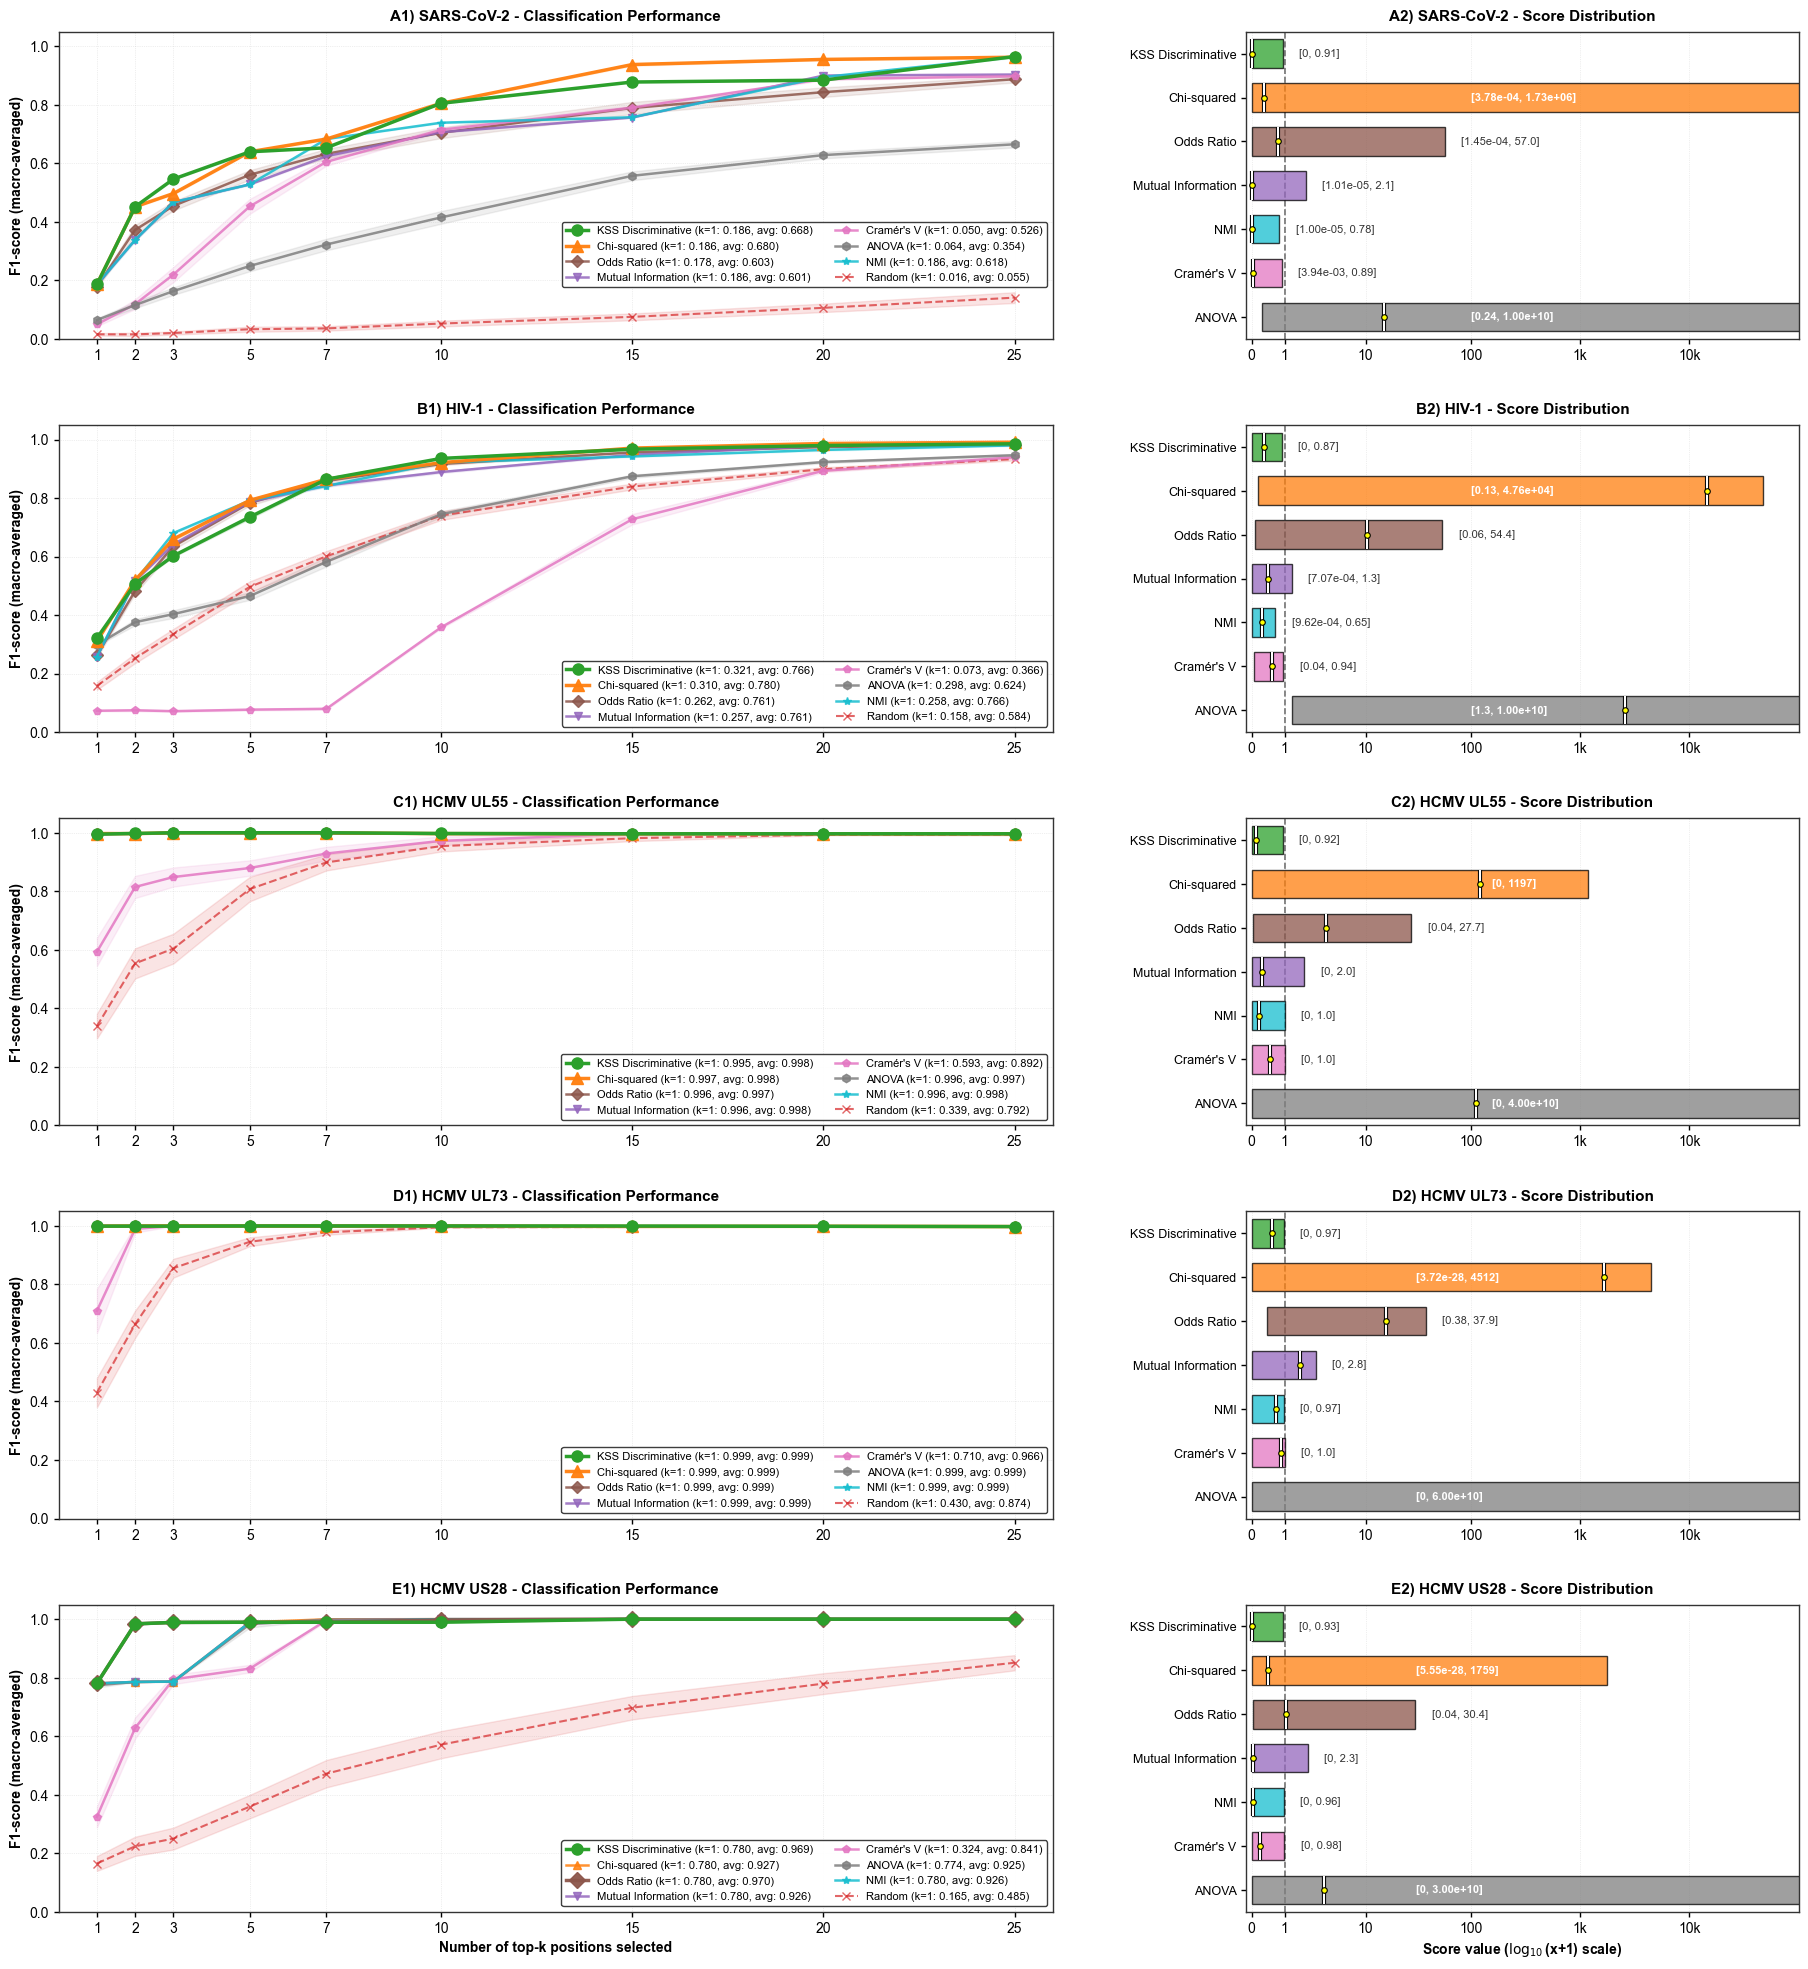

In [5]:
# Set publication-quality defaults
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans', 'Helvetica']
mpl.rcParams['axes.linewidth'] = 1.0
mpl.rcParams['axes.edgecolor'] = '#333333'
mpl.rcParams['xtick.major.width'] = 1.0
mpl.rcParams['ytick.major.width'] = 1.0
mpl.rcParams['xtick.direction'] = 'out'
mpl.rcParams['ytick.direction'] = 'out'

# Load data
results_file = OUTPUT_PATH / "results_by_gene.csv"
scores_file = OUTPUT_PATH / "discriminative_scores_all_positions.csv"

results_df = pd.read_csv(results_file)
scores_df = pd.read_csv(scores_file)

print(f"Loaded: {len(results_df):,} results by gene")
print(f"Loaded: {len(scores_df):,} position scores")

# === STYLE CONFIGURATION ===
METRICS_ORDER = [
    'KSS_discriminative', 'Chi2', 'OddsRatio', 'MI',
    'CramerV', 'ANOVA', 'NMI', 'Random'
]

METRICS_LABELS = {
    'KSS_discriminative': 'KSS Discriminative',
    'Chi2': 'Chi-squared',
    'MI': 'Mutual Information',
    'OddsRatio': 'Odds Ratio',
    'CramerV': "Cramér's V",
    'ANOVA': 'ANOVA',
    'NMI': 'NMI',
    'Random': 'Random',
}

METRICS_COLORS = {
    'KSS_discriminative': '#2ca02c',
    'Chi2': '#ff7f0e',
    'MI': '#9467bd',
    'OddsRatio': '#8c564b',
    'CramerV': '#e377c2',
    'ANOVA': '#7f7f7f',
    'NMI': '#17becf',
    'Random': '#d62728',
}

METRICS_MARKERS = {
    'KSS_discriminative': 'o',
    'Chi2': '^',
    'MI': 'v',
    'OddsRatio': 'D',
    'CramerV': 'p',
    'ANOVA': 'h',
    'NMI': '*',
    'Random': 'x',
}

# Panel B metrics order (excluding Random for distribution)
METRICS_PANEL_B = ['KSS_discriminative', 'Chi2', 'OddsRatio', 'MI', 'NMI', 'CramerV', 'ANOVA']

# X-axis limits for distribution panel
X_AXIS_MIN = -0.05
X_AXIS_MAX = 5.0

# Manual position for range text [min, max] - set X position in log10(x+1) scale
# Structure: {dataset_label: {metric: position}}
# If None or not specified, position is automatically after the bar
# Use this for metrics with very long bars (Chi2, ANOVA) to place text inside or at fixed position
RANGE_TEXT_POSITION = {
    'SARS-CoV-2': {
        'Chi2': 2.0,
        'ANOVA': 2.0,
    },
    'HIV-1': {
        'Chi2': 2.0,
        'ANOVA': 2.0,
    },
    'HCMV UL55': {
        'Chi2': 2.2,
        'ANOVA': 2.2,
    },
    'HCMV UL73': {
        'Chi2': 1.5,
        'ANOVA': 1.5,
    },
    'HCMV US28': {
        'Chi2': 1.5,
        'ANOVA': 1.5,
    },
}

# Text color when positioned inside bar (for contrast)
RANGE_TEXT_COLOR_INSIDE = 'white'
RANGE_TEXT_COLOR_OUTSIDE = '#333333'

# Legend position adjustment per dataset (for Panel 1 - Classification Performance)
# Format: (x, y) where x and y are in axes coordinates (0-1)
# Default is 'lower right', but can be fine-tuned with bbox_to_anchor
LEGEND_POSITION = {
    'SARS-CoV-2': {'loc': 'lower right', 'bbox_to_anchor': (1.0, 0.15)},  # Slightly higher
    'HIV-1': {'loc': 'lower right', 'bbox_to_anchor': None},
    'HCMV UL55': {'loc': 'lower right', 'bbox_to_anchor': None},
    'HCMV UL73': {'loc': 'lower right', 'bbox_to_anchor': None},
    'HCMV US28': {'loc': 'lower right', 'bbox_to_anchor': None},
}

# Dataset configuration
DATASETS = [
    {'dataset': 'SARS-CoV-2', 'gene': 'pooled', 'label': 'SARS-CoV-2', 'classes': 19, 'type': 'pooled'},
    {'dataset': 'HIV-1', 'gene': 'pooled', 'label': 'HIV-1', 'classes': 15, 'type': 'pooled'},
    {'dataset': 'HCMV', 'gene': 'UL55', 'label': 'HCMV UL55', 'classes': 4, 'type': 'gene-specific'},
    {'dataset': 'HCMV', 'gene': 'UL73', 'label': 'HCMV UL73', 'classes': 8, 'type': 'gene-specific'},
    {'dataset': 'HCMV', 'gene': 'US28', 'label': 'HCMV US28', 'classes': 6, 'type': 'gene-specific'},
]

ROW_LABELS = ['A', 'B', 'C', 'D', 'E']

# === HELPER FUNCTIONS ===
def get_dataset_label(row):
    return row['gene'] if row['dataset'] == 'HCMV' else row['dataset']

def get_dataset_data(ds_config, results_df, scores_df):
    """Extract data for a specific dataset"""
    dataset = ds_config['dataset']
    gene = ds_config['gene']
    
    if dataset == 'HCMV':
        results = results_df[(results_df['dataset'] == dataset) & (results_df['gene'] == gene)]
        scores = scores_df[scores_df['dataset_label'] == gene]
    else:
        results = results_df[results_df['dataset'] == dataset]
        scores = scores_df[scores_df['dataset_label'] == dataset]
    
    return results, scores

def get_ranking_info(df_dataset):
    """Get best method and KSS rank for a dataset (mean across all top_k)"""
    mean_f1 = df_dataset.groupby('metric')['test_f1_mean'].mean().sort_values(ascending=False)
    
    mean_f1_no_random = mean_f1.drop('Random', errors='ignore')
    best_method = mean_f1_no_random.index[0]
    best_f1 = mean_f1_no_random.iloc[0]
    
    kss_rank = list(mean_f1.index).index('KSS_discriminative') + 1 if 'KSS_discriminative' in mean_f1.index else None
    kss_f1 = mean_f1.get('KSS_discriminative', 0)
    
    return best_method, best_f1, kss_rank, kss_f1, mean_f1.to_dict()

# Add dataset label to scores
scores_df['dataset_label'] = scores_df.apply(get_dataset_label, axis=1)

# === CREATE FIGURE ===
fig = plt.figure(figsize=(20, 20))
gs = fig.add_gridspec(5, 2, width_ratios=[1.8, 1], wspace=0.25, hspace=0.28,
                      left=0.08, right=0.95, top=0.97, bottom=0.03)

for row_idx, ds_config in enumerate(DATASETS):
    
    df_results, df_scores = get_dataset_data(ds_config, results_df, scores_df)
    best_method, best_f1, kss_rank, kss_f1, mean_f1_dict = get_ranking_info(df_results)
    
    ax1 = fig.add_subplot(gs[row_idx, 0])  # Performance
    ax2 = fig.add_subplot(gs[row_idx, 1])  # Distribution
    
    # === PANEL 1: CLASSIFICATION PERFORMANCE ===
    # Pre-compute k=1 scores for legend
    k1_scores = {}
    for metric in METRICS_ORDER:
        df_k1 = df_results[(df_results['metric'] == metric) & (df_results['top_k'] == 1)]
        if len(df_k1) > 0:
            k1_scores[metric] = df_k1['test_f1_mean'].mean()
        else:
            k1_scores[metric] = np.nan
    
    for metric in METRICS_ORDER:
        df_m = df_results[df_results['metric'] == metric].sort_values('top_k')
        if len(df_m) == 0:
            continue
        
        avg_f1 = mean_f1_dict.get(metric, 0)
        k1_f1 = k1_scores.get(metric, np.nan)
        
        # Legend label with k=1 and avg scores
        if np.isnan(k1_f1):
            label = f"{METRICS_LABELS[metric]} (avg: {avg_f1:.3f})"
        else:
            label = f"{METRICS_LABELS[metric]} (k=1: {k1_f1:.3f}, avg: {avg_f1:.3f})"
        
        color = METRICS_COLORS[metric]
        marker = METRICS_MARKERS[metric]
        
        if metric == 'KSS_discriminative':
            line_width, marker_size, alpha, zorder = 2.5, 8, 1.0, 15
        elif metric == best_method:
            line_width, marker_size, alpha, zorder = 2.5, 8, 0.95, 12
        elif metric == 'Random':
            line_width, marker_size, alpha, zorder = 1.5, 6, 0.7, 1
        else:
            line_width, marker_size, alpha, zorder = 1.8, 6, 0.85, 5
        
        line_style = '--' if metric == 'Random' else '-'
        
        ax1.plot(df_m['top_k'], df_m['test_f1_mean'], label=label, color=color,
                marker=marker, markersize=marker_size, linewidth=line_width,
                linestyle=line_style, alpha=alpha, zorder=zorder)
        
        if 'test_f1_ci95' in df_m.columns:
            ax1.fill_between(df_m['top_k'], 
                           df_m['test_f1_mean'] - df_m['test_f1_ci95'],
                           df_m['test_f1_mean'] + df_m['test_f1_ci95'],
                           color=color, alpha=0.12, zorder=1)
    
    k_values = sorted(df_results['top_k'].unique())
    
    # X label only on bottom row
    if row_idx == len(DATASETS) - 1:
        ax1.set_xlabel('Number of top-k positions selected', fontsize=10, fontweight='bold')
    
    ax1.set_ylabel('F1-score (macro-averaged)', fontsize=10, fontweight='bold')
    
    # Descriptive centered title
    ax1.set_title(f'{ROW_LABELS[row_idx]}1) {ds_config["label"]} - Classification Performance', 
                  fontsize=11, fontweight='bold', loc='center', pad=8)
    
    ax1.grid(True, linestyle=':', alpha=0.4, linewidth=0.5)
    ax1.set_axisbelow(True)
    ax1.set_xticks(k_values)
    ax1.set_xlim(0, max(k_values) + 1)
    ax1.set_ylim(0, 1.05)
    ax1.set_yticks(np.arange(0, 1.1, 0.2))
    
    # Legend with per-dataset positioning
    legend_config = LEGEND_POSITION.get(ds_config['label'], {'loc': 'lower right', 'bbox_to_anchor': None})
    if legend_config['bbox_to_anchor']:
        legend = ax1.legend(loc=legend_config['loc'], 
                           bbox_to_anchor=legend_config['bbox_to_anchor'],
                           frameon=True, framealpha=0.95, 
                           edgecolor='#333333', fontsize=8, ncol=2)
    else:
        legend = ax1.legend(loc=legend_config['loc'], 
                           frameon=True, framealpha=0.95, 
                           edgecolor='#333333', fontsize=8, ncol=2)
    
    # === PANEL 2: SCORE DISTRIBUTION ===
    y_positions = np.arange(len(METRICS_PANEL_B))
    box_height = 0.65
    
    for i, metric in enumerate(METRICS_PANEL_B):
        if metric not in df_scores.columns:
            continue
        
        values = df_scores[metric].dropna()
        values_finite = values[np.isfinite(values)]
        
        if len(values_finite) == 0:
            continue
        
        log_values = np.log10(values_finite + 1)
        
        val_min = np.min(log_values)
        val_max = np.max(log_values)
        val_median = np.median(log_values)
        
        orig_min = values_finite.min()
        orig_max = values_finite.max()
        
        color = METRICS_COLORS[metric]
        
        bar_width = val_max - val_min
        ax2.barh(i, bar_width, left=val_min, height=box_height,
                color=color, edgecolor='black', linewidth=1.0, alpha=0.75)
        
        ax2.plot([val_median, val_median], [i - box_height/2, i + box_height/2],
                color='black', linewidth=3.0, zorder=11, solid_capstyle='butt')
        ax2.plot([val_median, val_median], [i - box_height/2, i + box_height/2],
                color='white', linewidth=1.5, zorder=12, solid_capstyle='butt')
        ax2.plot(val_median, i, marker='o', markersize=4, color='yellow',
                markeredgecolor='black', markeredgewidth=0.8, zorder=13)
        
        # Format range text with consistent significant figures
        def format_value(val):
            """Format value with consistent significant figures"""
            if val == 0:
                return '0'
            elif abs(val) < 0.01:
                return f'{val:.2e}'
            elif abs(val) < 1:
                return f'{val:.2f}'
            elif abs(val) < 100:
                return f'{val:.1f}'
            elif abs(val) < 10000:
                return f'{val:.0f}'
            else:
                return f'{val:.2e}'
        
        range_text = f'[{format_value(orig_min)}, {format_value(orig_max)}]'
        
        # Determine text position and color
        dataset_positions = RANGE_TEXT_POSITION.get(ds_config['label'], {})
        manual_pos = dataset_positions.get(metric, None)
        
        if manual_pos is not None:
            text_x = manual_pos
            # Check if position is inside the bar
            if val_min < text_x < val_max:
                text_color = RANGE_TEXT_COLOR_INSIDE
                text_weight = 'bold'
            else:
                text_color = RANGE_TEXT_COLOR_OUTSIDE
                text_weight = 'normal'
        else:
            text_x = val_max + 0.15
            text_color = RANGE_TEXT_COLOR_OUTSIDE
            text_weight = 'normal'
        
        ax2.text(text_x, i, range_text, va='center', fontsize=8, 
                color=text_color, fontweight=text_weight)
    
    # Reference line at x=1 (log10(2) ≈ 0.301)
    ref_x = np.log10(2)
    ax2.axvline(ref_x, color='#333333', linestyle='--', linewidth=1.2, alpha=0.7, zorder=0)
    
    ax2.set_yticks(y_positions)
    ax2.set_yticklabels([METRICS_LABELS[m] for m in METRICS_PANEL_B], fontsize=9)
    
    # X label only on bottom row
    if row_idx == len(DATASETS) - 1:
        ax2.set_xlabel(r'Score value ($\log_{10}$(x+1) scale)', fontsize=10, fontweight='bold')
    
    ax2.set_title(f'{ROW_LABELS[row_idx]}2) {ds_config["label"]} - Score Distribution', 
                  fontsize=11, fontweight='bold', loc='center', pad=8)
    ax2.set_xlim(X_AXIS_MIN, X_AXIS_MAX)
    ax2.set_ylim(-0.5, len(METRICS_PANEL_B) - 0.5)
    
    # X-axis ticks: show actual score values (x), not log values
    # log10(x+1) scale, so tick at log10(x+1) corresponds to score x
    # x=0 -> log10(1)=0, x=1 -> log10(2)≈0.301, x=9 -> log10(10)=1, x=99 -> log10(100)=2, etc.
    tick_scores = [0, 1, 10, 100, 1000, 10000]  # Actual score values
    tick_positions = [np.log10(x + 1) for x in tick_scores]  # Their positions on the axis
    tick_labels = ['0', '1', '10', '100', '1k', '10k']
    
    # Filter ticks within axis limits
    valid_ticks = [(pos, lab) for pos, lab in zip(tick_positions, tick_labels) if X_AXIS_MIN <= pos <= X_AXIS_MAX]
    ax2.set_xticks([t[0] for t in valid_ticks])
    ax2.set_xticklabels([t[1] for t in valid_ticks])
    
    ax2.grid(True, axis='x', linestyle=':', alpha=0.4, linewidth=0.5)
    ax2.set_axisbelow(True)
    ax2.invert_yaxis()

# === SAVE FIGURE ===
plt.savefig(OUTPUT_PATH / "discriminative_validation_by_dataset.pdf", dpi=300, bbox_inches='tight')
plt.savefig(OUTPUT_PATH / "discriminative_validation_by_dataset.png", dpi=300, bbox_inches='tight')
print(f"\n✓ Saved: discriminative_validation_by_dataset.pdf/png")

plt.show()

Loaded: 360 results by gene
Loaded: 4,285 position scores

✓ Saved: discriminative_validation_by_dataset.pdf/png


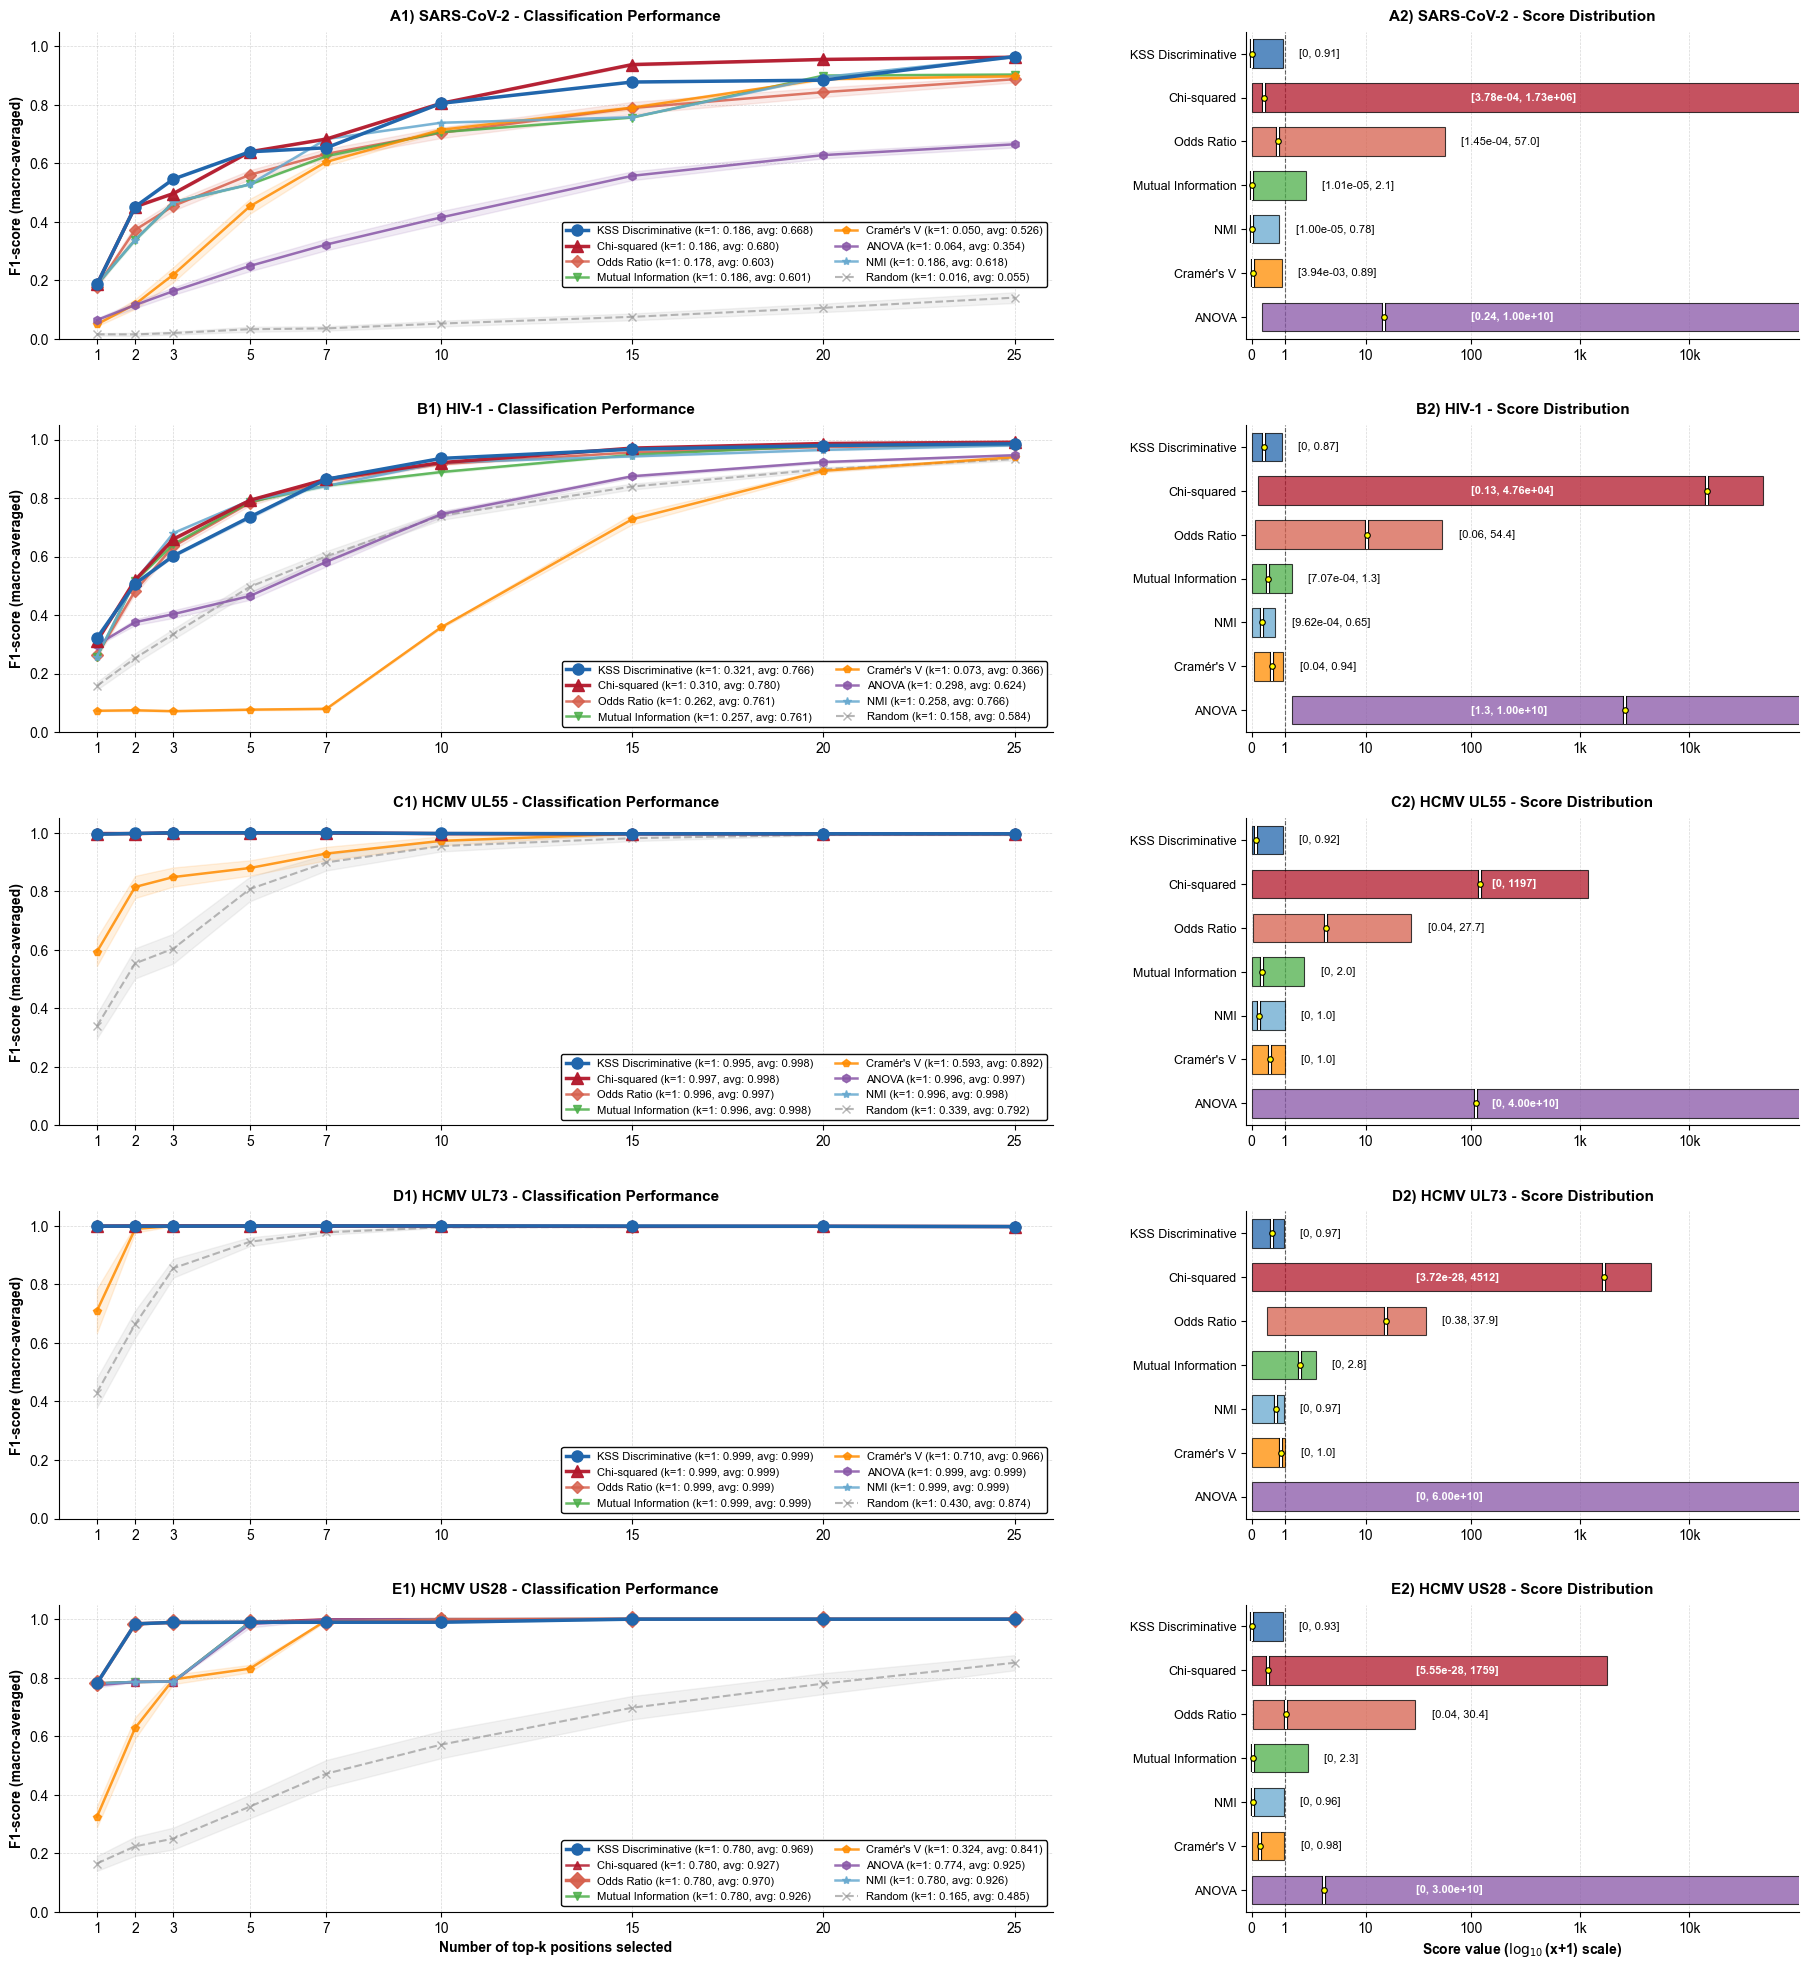

In [5]:
# Set publication-quality defaults (harmonized with generate_kss_figure)
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans', 'Liberation Sans', 'sans-serif']
mpl.rcParams['axes.linewidth'] = 0.8
mpl.rcParams['axes.edgecolor'] = '#000000'
mpl.rcParams['xtick.major.width'] = 0.8
mpl.rcParams['ytick.major.width'] = 0.8
mpl.rcParams['xtick.color'] = '#000000'
mpl.rcParams['ytick.color'] = '#000000'
mpl.rcParams['text.color'] = '#000000'
mpl.rcParams['xtick.direction'] = 'out'
mpl.rcParams['ytick.direction'] = 'out'
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

# Load data
results_file = OUTPUT_PATH / "results_by_gene.csv"
scores_file = OUTPUT_PATH / "discriminative_scores_all_positions.csv"

results_df = pd.read_csv(results_file)
scores_df = pd.read_csv(scores_file)

print(f"Loaded: {len(results_df):,} results by gene")
print(f"Loaded: {len(scores_df):,} position scores")

# === STYLE CONFIGURATION ===
# RdBu divergent palette harmonized with generate_kss_figure
# KSS blue (#2166AC) and discriminative red (#D6604D) are anchors

METRICS_ORDER = [
    'KSS_discriminative', 'Chi2', 'OddsRatio', 'MI',
    'CramerV', 'ANOVA', 'NMI', 'Random'
]

METRICS_LABELS = {
    'KSS_discriminative': 'KSS Discriminative',
    'Chi2': 'Chi-squared',
    'MI': 'Mutual Information',
    'OddsRatio': 'Odds Ratio',
    'CramerV': "Cramér's V",
    'ANOVA': 'ANOVA',
    'NMI': 'NMI',
    'Random': 'Random',
}

METRICS_COLORS = {
      'KSS_discriminative': '#2166AC',  # KSS blue (ancre)
      'Chi2': '#B2182B',                # Dark crimson (ancre)
      'OddsRatio': '#D6604D',           # Red-orange (ancre)
      'MI': '#4DAF4A',                  # Green (ancre)
      'CramerV': '#FF8C00',             # Dark orange
      'ANOVA': '#8856A7',               # Purple
      'NMI': '#67A9CF',                 # Teal blue
      'Random': '#999999',              # Neutral gray
  }

METRICS_MARKERS = {
    'KSS_discriminative': 'o',
    'Chi2': '^',
    'MI': 'v',
    'OddsRatio': 'D',
    'CramerV': 'p',
    'ANOVA': 'h',
    'NMI': '*',
    'Random': 'x',
}

# Panel B metrics order (excluding Random for distribution)
METRICS_PANEL_B = ['KSS_discriminative', 'Chi2', 'OddsRatio', 'MI', 'NMI', 'CramerV', 'ANOVA']

# X-axis limits for distribution panel
X_AXIS_MIN = -0.05
X_AXIS_MAX = 5.0

# Manual position for range text [min, max] - set X position in log10(x+1) scale
RANGE_TEXT_POSITION = {
    'SARS-CoV-2': {
        'Chi2': 2.0,
        'ANOVA': 2.0,
    },
    'HIV-1': {
        'Chi2': 2.0,
        'ANOVA': 2.0,
    },
    'HCMV UL55': {
        'Chi2': 2.2,
        'ANOVA': 2.2,
    },
    'HCMV UL73': {
        'Chi2': 1.5,
        'ANOVA': 1.5,
    },
    'HCMV US28': {
        'Chi2': 1.5,
        'ANOVA': 1.5,
    },
}

# Text color when positioned inside bar (for contrast)
RANGE_TEXT_COLOR_INSIDE = 'white'
RANGE_TEXT_COLOR_OUTSIDE = '#000000'

# Legend position adjustment per dataset
LEGEND_POSITION = {
    'SARS-CoV-2': {'loc': 'lower right', 'bbox_to_anchor': (1.0, 0.15)},
    'HIV-1': {'loc': 'lower right', 'bbox_to_anchor': None},
    'HCMV UL55': {'loc': 'lower right', 'bbox_to_anchor': None},
    'HCMV UL73': {'loc': 'lower right', 'bbox_to_anchor': None},
    'HCMV US28': {'loc': 'lower right', 'bbox_to_anchor': None},
}

# Dataset configuration
DATASETS = [
    {'dataset': 'SARS-CoV-2', 'gene': 'pooled', 'label': 'SARS-CoV-2', 'classes': 19, 'type': 'pooled'},
    {'dataset': 'HIV-1', 'gene': 'pooled', 'label': 'HIV-1', 'classes': 15, 'type': 'pooled'},
    {'dataset': 'HCMV', 'gene': 'UL55', 'label': 'HCMV UL55', 'classes': 4, 'type': 'gene-specific'},
    {'dataset': 'HCMV', 'gene': 'UL73', 'label': 'HCMV UL73', 'classes': 8, 'type': 'gene-specific'},
    {'dataset': 'HCMV', 'gene': 'US28', 'label': 'HCMV US28', 'classes': 6, 'type': 'gene-specific'},
]

ROW_LABELS = ['A', 'B', 'C', 'D', 'E']

# === HELPER FUNCTIONS ===
def get_dataset_label(row):
    return row['gene'] if row['dataset'] == 'HCMV' else row['dataset']

def get_dataset_data(ds_config, results_df, scores_df):
    """Extract data for a specific dataset"""
    dataset = ds_config['dataset']
    gene = ds_config['gene']

    if dataset == 'HCMV':
        results = results_df[(results_df['dataset'] == dataset) & (results_df['gene'] == gene)]
        scores = scores_df[scores_df['dataset_label'] == gene]
    else:
        results = results_df[results_df['dataset'] == dataset]
        scores = scores_df[scores_df['dataset_label'] == dataset]

    return results, scores

def get_ranking_info(df_dataset):
    """Get best method and KSS rank for a dataset (mean across all top_k)"""
    mean_f1 = df_dataset.groupby('metric')['test_f1_mean'].mean().sort_values(ascending=False)

    mean_f1_no_random = mean_f1.drop('Random', errors='ignore')
    best_method = mean_f1_no_random.index[0]
    best_f1 = mean_f1_no_random.iloc[0]

    kss_rank = list(mean_f1.index).index('KSS_discriminative') + 1 if 'KSS_discriminative' in mean_f1.index else None
    kss_f1 = mean_f1.get('KSS_discriminative', 0)

    return best_method, best_f1, kss_rank, kss_f1, mean_f1.to_dict()

# Add dataset label to scores
scores_df['dataset_label'] = scores_df.apply(get_dataset_label, axis=1)

# === CREATE FIGURE ===
fig = plt.figure(figsize=(20, 20), facecolor='white')
gs = fig.add_gridspec(5, 2, width_ratios=[1.8, 1], wspace=0.25, hspace=0.28,
                    left=0.08, right=0.95, top=0.97, bottom=0.03)

for row_idx, ds_config in enumerate(DATASETS):

    df_results, df_scores = get_dataset_data(ds_config, results_df, scores_df)
    best_method, best_f1, kss_rank, kss_f1, mean_f1_dict = get_ranking_info(df_results)

    ax1 = fig.add_subplot(gs[row_idx, 0])  # Performance
    ax2 = fig.add_subplot(gs[row_idx, 1])  # Distribution

    # Remove top and right spines (match generate_kss_figure)
    for ax in [ax1, ax2]:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_linewidth(0.8)
        ax.spines['bottom'].set_linewidth(0.8)

    # === PANEL 1: CLASSIFICATION PERFORMANCE ===
    # Pre-compute k=1 scores for legend
    k1_scores = {}
    for metric in METRICS_ORDER:
        df_k1 = df_results[(df_results['metric'] == metric) & (df_results['top_k'] == 1)]
        if len(df_k1) > 0:
            k1_scores[metric] = df_k1['test_f1_mean'].mean()
        else:
            k1_scores[metric] = np.nan

    for metric in METRICS_ORDER:
        df_m = df_results[df_results['metric'] == metric].sort_values('top_k')
        if len(df_m) == 0:
            continue

        avg_f1 = mean_f1_dict.get(metric, 0)
        k1_f1 = k1_scores.get(metric, np.nan)

        # Legend label with k=1 and avg scores
        if np.isnan(k1_f1):
            label = f"{METRICS_LABELS[metric]} (avg: {avg_f1:.3f})"
        else:
            label = f"{METRICS_LABELS[metric]} (k=1: {k1_f1:.3f}, avg: {avg_f1:.3f})"

        color = METRICS_COLORS[metric]
        marker = METRICS_MARKERS[metric]

        if metric == 'KSS_discriminative':
            line_width, marker_size, alpha, zorder = 2.5, 8, 1.0, 15
        elif metric == best_method:
            line_width, marker_size, alpha, zorder = 2.5, 8, 0.95, 12
        elif metric == 'Random':
            line_width, marker_size, alpha, zorder = 1.5, 6, 0.7, 1
        else:
            line_width, marker_size, alpha, zorder = 1.8, 6, 0.85, 5

        line_style = '--' if metric == 'Random' else '-'

        ax1.plot(df_m['top_k'], df_m['test_f1_mean'], label=label, color=color,
                marker=marker, markersize=marker_size, linewidth=line_width,
                linestyle=line_style, alpha=alpha, zorder=zorder)

        if 'test_f1_ci95' in df_m.columns:
            ax1.fill_between(df_m['top_k'],
                            df_m['test_f1_mean'] - df_m['test_f1_ci95'],
                            df_m['test_f1_mean'] + df_m['test_f1_ci95'],
                            color=color, alpha=0.12, zorder=1)

    k_values = sorted(df_results['top_k'].unique())

    if row_idx == len(DATASETS) - 1:
        ax1.set_xlabel('Number of top-k positions selected', fontsize=10, fontweight='bold')

    ax1.set_ylabel('F1-score (macro-averaged)', fontsize=10, fontweight='bold')

    ax1.set_title(f'{ROW_LABELS[row_idx]}1) {ds_config["label"]} - Classification Performance',
                fontsize=11, fontweight='bold', loc='center', pad=8)

    ax1.grid(True, linestyle='--', alpha=0.5, linewidth=0.5)
    ax1.set_axisbelow(True)
    ax1.set_xticks(k_values)
    ax1.set_xlim(0, max(k_values) + 1)
    ax1.set_ylim(0, 1.05)
    ax1.set_yticks(np.arange(0, 1.1, 0.2))

    # Legend
    legend_config = LEGEND_POSITION.get(ds_config['label'], {'loc': 'lower right', 'bbox_to_anchor': None})
    if legend_config['bbox_to_anchor']:
        legend = ax1.legend(loc=legend_config['loc'],
                            bbox_to_anchor=legend_config['bbox_to_anchor'],
                            frameon=True, framealpha=0.95,
                            edgecolor='black', fontsize=8, ncol=2)
    else:
        legend = ax1.legend(loc=legend_config['loc'],
                            frameon=True, framealpha=0.95,
                            edgecolor='black', fontsize=8, ncol=2)

    # === PANEL 2: SCORE DISTRIBUTION ===
    y_positions = np.arange(len(METRICS_PANEL_B))
    box_height = 0.65

    for i, metric in enumerate(METRICS_PANEL_B):
        if metric not in df_scores.columns:
            continue

        values = df_scores[metric].dropna()
        values_finite = values[np.isfinite(values)]

        if len(values_finite) == 0:
            continue

        log_values = np.log10(values_finite + 1)

        val_min = np.min(log_values)
        val_max = np.max(log_values)
        val_median = np.median(log_values)

        orig_min = values_finite.min()
        orig_max = values_finite.max()

        color = METRICS_COLORS[metric]

        bar_width = val_max - val_min
        ax2.barh(i, bar_width, left=val_min, height=box_height,
                color=color, edgecolor='black', linewidth=0.8, alpha=0.75)

        ax2.plot([val_median, val_median], [i - box_height/2, i + box_height/2],
                color='black', linewidth=3.0, zorder=11, solid_capstyle='butt')
        ax2.plot([val_median, val_median], [i - box_height/2, i + box_height/2],
                color='white', linewidth=1.5, zorder=12, solid_capstyle='butt')
        ax2.plot(val_median, i, marker='o', markersize=4, color='yellow',
                markeredgecolor='black', markeredgewidth=0.8, zorder=13)

        def format_value(val):
            if val == 0:
                return '0'
            elif abs(val) < 0.01:
                return f'{val:.2e}'
            elif abs(val) < 1:
                return f'{val:.2f}'
            elif abs(val) < 100:
                return f'{val:.1f}'
            elif abs(val) < 10000:
                return f'{val:.0f}'
            else:
                return f'{val:.2e}'

        range_text = f'[{format_value(orig_min)}, {format_value(orig_max)}]'

        dataset_positions = RANGE_TEXT_POSITION.get(ds_config['label'], {})
        manual_pos = dataset_positions.get(metric, None)

        if manual_pos is not None:
            text_x = manual_pos
            if val_min < text_x < val_max:
                text_color = RANGE_TEXT_COLOR_INSIDE
                text_weight = 'bold'
            else:
                text_color = RANGE_TEXT_COLOR_OUTSIDE
                text_weight = 'normal'
        else:
            text_x = val_max + 0.15
            text_color = RANGE_TEXT_COLOR_OUTSIDE
            text_weight = 'normal'

        ax2.text(text_x, i, range_text, va='center', fontsize=8,
                color=text_color, fontweight=text_weight)

    # Reference line at x=1 (log10(2))
    ref_x = np.log10(2)
    ax2.axvline(ref_x, color='black', linestyle='--', linewidth=0.8, alpha=0.7, zorder=0)

    ax2.set_yticks(y_positions)
    ax2.set_yticklabels([METRICS_LABELS[m] for m in METRICS_PANEL_B], fontsize=9)

    if row_idx == len(DATASETS) - 1:
        ax2.set_xlabel(r'Score value ($\log_{10}$(x+1) scale)', fontsize=10, fontweight='bold')

    ax2.set_title(f'{ROW_LABELS[row_idx]}2) {ds_config["label"]} - Score Distribution',
                fontsize=11, fontweight='bold', loc='center', pad=8)
    ax2.set_xlim(X_AXIS_MIN, X_AXIS_MAX)
    ax2.set_ylim(-0.5, len(METRICS_PANEL_B) - 0.5)

    tick_scores = [0, 1, 10, 100, 1000, 10000]
    tick_positions = [np.log10(x + 1) for x in tick_scores]
    tick_labels = ['0', '1', '10', '100', '1k', '10k']

    valid_ticks = [(pos, lab) for pos, lab in zip(tick_positions, tick_labels) if X_AXIS_MIN <= pos <= X_AXIS_MAX]
    ax2.set_xticks([t[0] for t in valid_ticks])
    ax2.set_xticklabels([t[1] for t in valid_ticks])

    ax2.grid(True, axis='x', linestyle='--', alpha=0.5, linewidth=0.5)
    ax2.set_axisbelow(True)
    ax2.invert_yaxis()

# === SAVE FIGURE ===
plt.savefig(OUTPUT_PATH / "discriminative_validation_by_dataset.pdf", dpi=600, bbox_inches='tight',
            facecolor='white', edgecolor='none')
plt.savefig(OUTPUT_PATH / "discriminative_validation_by_dataset.png", dpi=300, bbox_inches='tight',
            facecolor='white', edgecolor='none')
print(f"\n✓ Saved: discriminative_validation_by_dataset.pdf/png")

plt.show()

In [61]:
# Load results
results_file = OUTPUT_PATH / "results_by_gene.csv"
results_df = pd.read_csv(results_file)

# ============================================================================
# CONFIGURATION
# ============================================================================

DATASETS_CONFIG = [
    {'dataset': 'SARS-CoV-2', 'gene': 'pooled', 'label': 'SARS-CoV-2', 'classes': 19},
    {'dataset': 'HIV-1', 'gene': 'pooled', 'label': 'HIV-1', 'classes': 15},
    {'dataset': 'HCMV', 'gene': 'UL55', 'label': 'HCMV UL55', 'classes': 4},
    {'dataset': 'HCMV', 'gene': 'UL73', 'label': 'HCMV UL73', 'classes': 8},
    {'dataset': 'HCMV', 'gene': 'US28', 'label': 'HCMV US28', 'classes': 6},
]

METRICS_ORDER = [
    'KSS_discriminative', 'Chi2', 'OddsRatio', 'MI',
    'CramerV', 'ANOVA', 'NMI', 'Random'
]

METRICS_LABELS = {
    'KSS_discriminative': 'KSS Discriminative',
    'Chi2': 'Chi-squared',
    'MI': 'Mutual Information',
    'OddsRatio': 'Odds Ratio',
    'CramerV': "Cramér's V",
    'ANOVA': 'ANOVA',
    'NMI': 'NMI',
    'Random': 'Random',
}

# ============================================================================
# HELPER FUNCTIONS
# ============================================================================

def get_dataset_data(ds_config, results_df):
    """Extract data for a specific dataset"""
    dataset = ds_config['dataset']
    gene = ds_config['gene']

    if dataset == 'HCMV':
        return results_df[(results_df['dataset'] == dataset) & (results_df['gene'] == gene)]
    else:
        return results_df[results_df['dataset'] == dataset]

# ============================================================================
# GENERATE TABLES
# ============================================================================

all_top_k = sorted(results_df['top_k'].unique())

print("=" * 120)
print("DETAILED F1 SCORES BY DATASET AND TOP-K")
print("=" * 120)
print()

for ds_config in DATASETS_CONFIG:
    df = get_dataset_data(ds_config, results_df)
    label = ds_config['label']
    n_classes = ds_config['classes']

    print("=" * 120)
    print(f"{label} ({n_classes} classes)")
    print("=" * 120)

    # Build DataFrame
    table_data = []
    for metric in METRICS_ORDER:
        row = {'Metric': METRICS_LABELS.get(metric, metric)}
        f1_values = []

        for k in all_top_k:
            df_k = df[(df['metric'] == metric) & (df['top_k'] == k)]
            if len(df_k) > 0:
                f1 = df_k['test_f1_mean'].mean()
                row[f'k={k}'] = round(f1, 3)
                f1_values.append(f1)
            else:
                row[f'k={k}'] = np.nan

        # Mean column
        row['Mean'] = round(np.nanmean(f1_values), 3) if f1_values else np.nan
        table_data.append(row)

    # Create DataFrame
    table_df = pd.DataFrame(table_data)

    # Display
    print()
    print(table_df.to_string(index=False))
    print()

    # Save individual table
    table_file = OUTPUT_PATH / f"table_{label.replace(' ', '_')}.csv"
    table_df.to_csv(table_file, index=False)
    print(f"✓ Saved: {table_file}")
    print()

print("=" * 120)
print("ALL TABLES GENERATED")
print("=" * 120)

DETAILED F1 SCORES BY DATASET AND TOP-K

SARS-CoV-2 (19 classes)

            Metric   k=1   k=2   k=3   k=5   k=7  k=10  k=15  k=20  k=25  Mean
KSS Discriminative 0.186 0.452 0.546 0.640 0.653 0.805 0.878 0.884 0.965 0.668
       Chi-squared 0.186 0.452 0.497 0.640 0.683 0.805 0.938 0.955 0.963 0.680
        Odds Ratio 0.178 0.373 0.454 0.561 0.632 0.705 0.790 0.843 0.888 0.603
Mutual Information 0.186 0.338 0.467 0.528 0.624 0.707 0.757 0.900 0.904 0.601
        Cramér's V 0.050 0.119 0.220 0.453 0.605 0.715 0.790 0.888 0.898 0.526
             ANOVA 0.064 0.116 0.163 0.249 0.323 0.415 0.558 0.628 0.665 0.354
               NMI 0.186 0.338 0.467 0.528 0.683 0.739 0.758 0.895 0.964 0.618
            Random 0.016 0.015 0.020 0.033 0.036 0.052 0.075 0.106 0.141 0.055

✓ Saved: c:\Users\lebat\Documents\Projects\KSS\notebooks\discriminative_score_validation_results\table_SARS-CoV-2.csv

HIV-1 (15 classes)

            Metric   k=1   k=2   k=3   k=5   k=7  k=10  k=15  k=20  k=25  Mean
KSS 

Loaded: 4,285 positions
✓ Saved: score_distributions.png/pdf


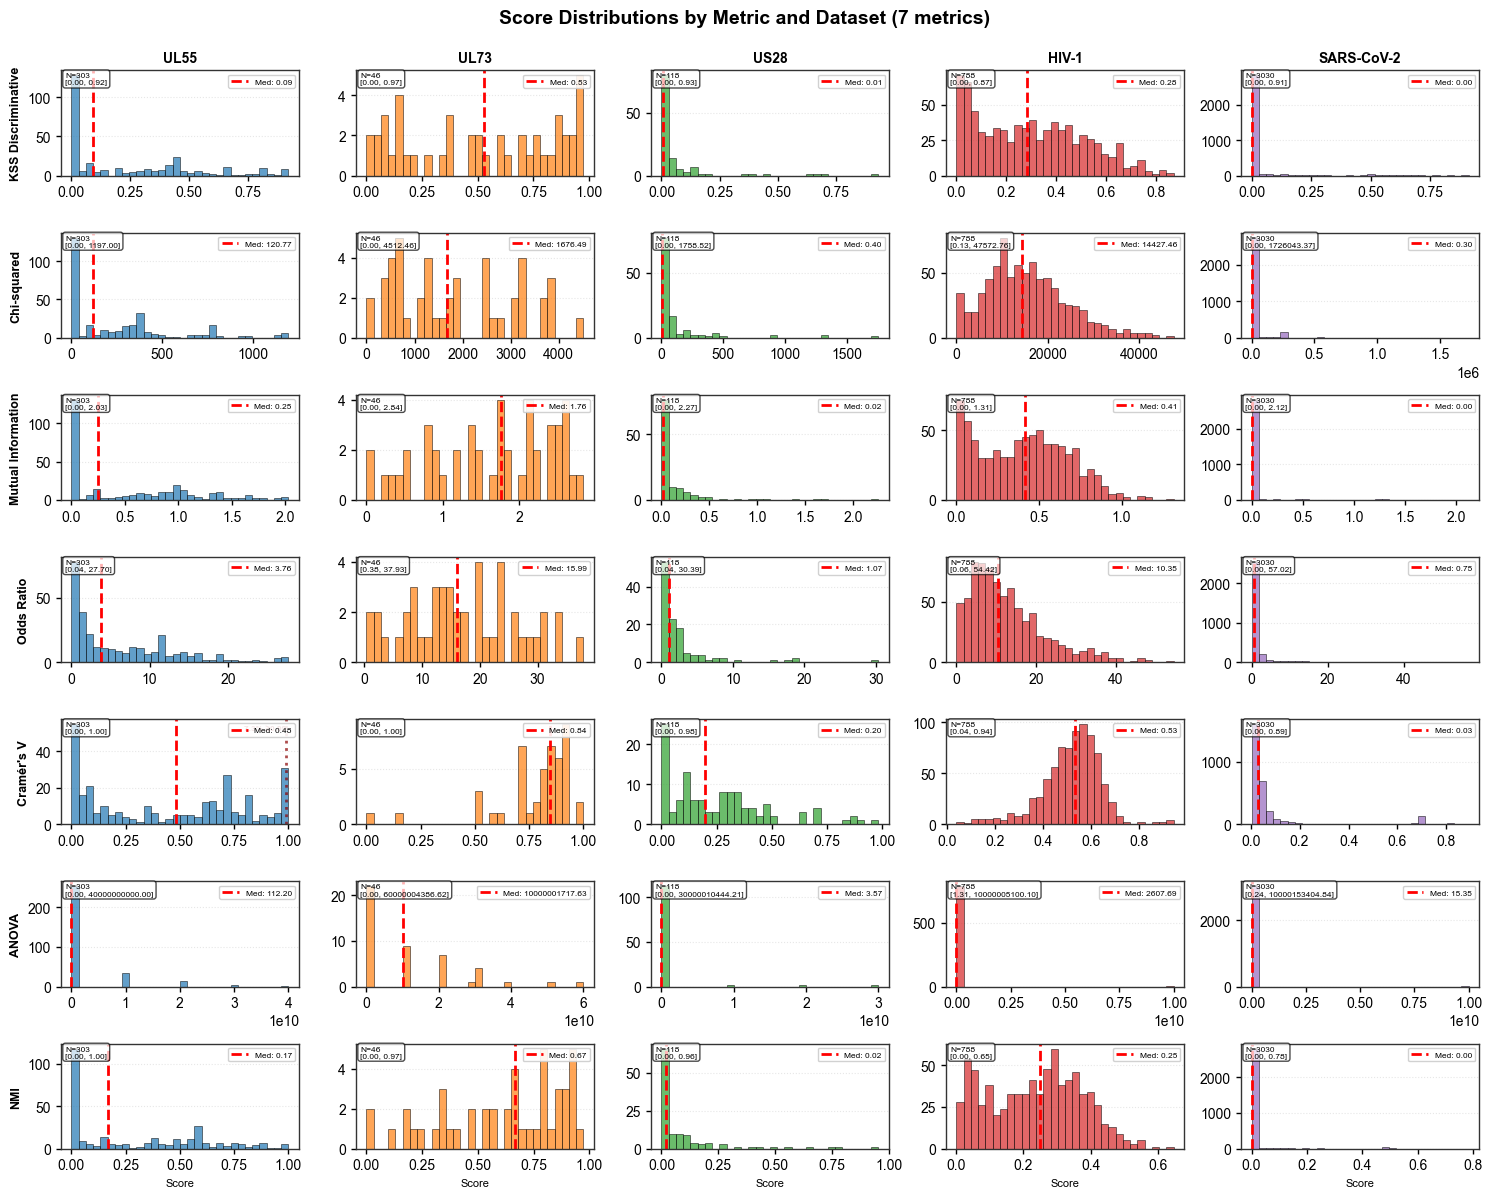

✓ Saved: score_statistics.csv

Score Statistics Summary:
            Metric    Min    P25  Median         Mean       P75          Max          Std Saturation_%    N
KSS Discriminative 0.0000 0.0000  0.0000 9.250000e-02    0.0570 9.750000e-01 1.899000e-01          0.0 4285
       Chi-squared 0.0000 0.0855  0.8255 2.200053e+04 1488.2800 1.726043e+06 8.570752e+04              4285
Mutual Information 0.0000 0.0002  0.0007 1.702000e-01    0.1207 2.844200e+00 3.668000e-01              4285
        Odds Ratio 0.0001 0.4476  1.0685 4.420700e+00    4.9443 5.702450e+01 7.292300e+00              4285
        Cramér's V 0.0000 0.0227  0.0502 2.131000e-01    0.4529 1.000000e+00 2.677000e-01         0.56 4285
             ANOVA 0.0000 6.9387 28.4696 3.361983e+08 1222.2823 6.000000e+10 2.729464e+09              4285
               NMI 0.0000 0.0002  0.0007 8.820000e-02    0.0822 1.000000e+00 1.734000e-01         0.05 4285


In [58]:
scores_file = OUTPUT_PATH / "discriminative_scores_all_positions.csv"
scores_df = pd.read_csv(scores_file)
print(f"Loaded: {len(scores_df):,} positions")

METRICS_TO_PLOT = ['KSS_discriminative', 'Chi2', 'MI', 'OddsRatio', 'CramerV', 'ANOVA', 'NMI']

# Labels
METRIC_LABELS = {
    'KSS_discriminative': 'KSS Discriminative',
    'Chi2': 'Chi-squared',
    'MI': 'Mutual Information',
    'OddsRatio': 'Odds Ratio',
    'CramerV': "Cramér's V",
    'ANOVA': 'ANOVA',
    'NMI': 'NMI',
}

DATASET_COLORS = {
    'UL55': '#1f77b4',
    'UL73': '#ff7f0e',
    'US28': '#2ca02c',
    'HIV-1': '#d62728',
    'SARS-CoV-2': '#9467bd'
}

def get_dataset_label(row):
    return row['gene'] if row['dataset'] == 'HCMV' else row['dataset']

scores_df['dataset_label'] = scores_df.apply(get_dataset_label, axis=1)
datasets = ['UL55', 'UL73', 'US28', 'HIV-1', 'SARS-CoV-2']

# Create figure
n_metrics = len(METRICS_TO_PLOT)
n_datasets = len(datasets)

fig, axes = plt.subplots(n_metrics, n_datasets, figsize=(15, 12))

for i, metric in enumerate(METRICS_TO_PLOT):
    for j, ds_label in enumerate(datasets):
        ax = axes[i, j]
        values = scores_df[scores_df['dataset_label'] == ds_label][metric].dropna()
        values = values[np.isfinite(values)]

        if len(values) == 0:
            ax.text(0.5, 0.5, 'No data', ha='center', va='center', fontsize=9)
            ax.set_xticks([])
            ax.set_yticks([])
            continue

        # Plot histogram
        ax.hist(values, bins=30, color=DATASET_COLORS[ds_label], alpha=0.7, edgecolor='black', linewidth=0.5)

        # Add median line
        median_val = np.median(values)
        ax.axvline(median_val, color='red', linestyle='--', linewidth=2, label=f'Med: {median_val:.2f}')

        # Check for saturation (bounded metrics only)
        if metric in ['KSS_discriminative', 'NMI', 'CramerV']:
            n_saturated = (values >= 0.99).sum()
            if n_saturated > 0:
                saturation_pct = 100 * n_saturated / len(values)
                if saturation_pct > 5:  # Show if >5% saturated
                    ax.axvline(0.99, color='darkred', linestyle=':', linewidth=2, alpha=0.7)
                    ax.text(0.99, ax.get_ylim()[1] * 0.9, f'{saturation_pct:.1f}% ≥0.99',
                           fontsize=6, ha='right', color='darkred', fontweight='bold')

        # Labels
        if j == 0:
            ax.set_ylabel(METRIC_LABELS.get(metric, metric), fontsize=9, fontweight='bold')
        if i == 0:
            ax.set_title(ds_label, fontsize=10, fontweight='bold')
        if i == n_metrics - 1:
            ax.set_xlabel('Score', fontsize=8)

        # Styling
        ax.grid(True, axis='y', alpha=0.3, linestyle=':')
        ax.set_axisbelow(True)
        ax.legend(fontsize=6, loc='upper right', framealpha=0.9)

        # Stats box
        stats_text = f'N={len(values)}\n[{values.min():.2f}, {values.max():.2f}]'
        ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, fontsize=6,
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

plt.suptitle(f'Score Distributions by Metric and Dataset ({n_metrics} metrics)',
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()

plt.savefig(OUTPUT_PATH / "score_distributions.png", dpi=300, bbox_inches='tight')
plt.savefig(OUTPUT_PATH / "score_distributions.pdf", bbox_inches='tight')
print("✓ Saved: score_distributions.png/pdf")
plt.show()

# ============================================================================
# STATISTICS TABLE
# ============================================================================

stats_list = []
for metric in METRICS_TO_PLOT:
    values = scores_df[metric].dropna()
    values = values[np.isfinite(values)]
    if len(values) == 0:
        continue

    # Check saturation for bounded metrics
    saturation_pct = np.nan
    if metric in ['KSS_discriminative', 'NMI', 'CramerV']:
        n_saturated = (values >= 0.99).sum()
        saturation_pct = 100 * n_saturated / len(values)

    stats_list.append({
        'Metric': METRIC_LABELS.get(metric, metric),
        'Min': round(values.min(), 4),
        'P25': round(np.percentile(values, 25), 4),
        'Median': round(np.median(values), 4),
        'Mean': round(values.mean(), 4),
        'P75': round(np.percentile(values, 75), 4),
        'Max': round(values.max(), 4),
        'Std': round(values.std(), 4),
        'Saturation_%': round(saturation_pct, 2) if not np.isnan(saturation_pct) else '',
        'N': len(values)
    })

stats_summary = pd.DataFrame(stats_list)
stats_summary.to_csv(OUTPUT_PATH / "score_statistics.csv", index=False)
print("✓ Saved: score_statistics.csv")
print("\nScore Statistics Summary:")
print(stats_summary.to_string(index=False))
